# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

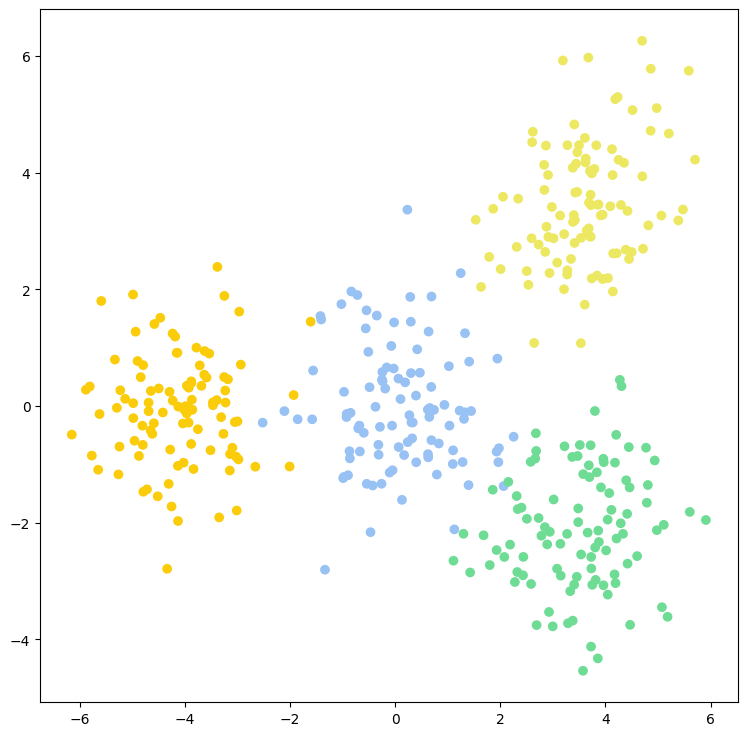

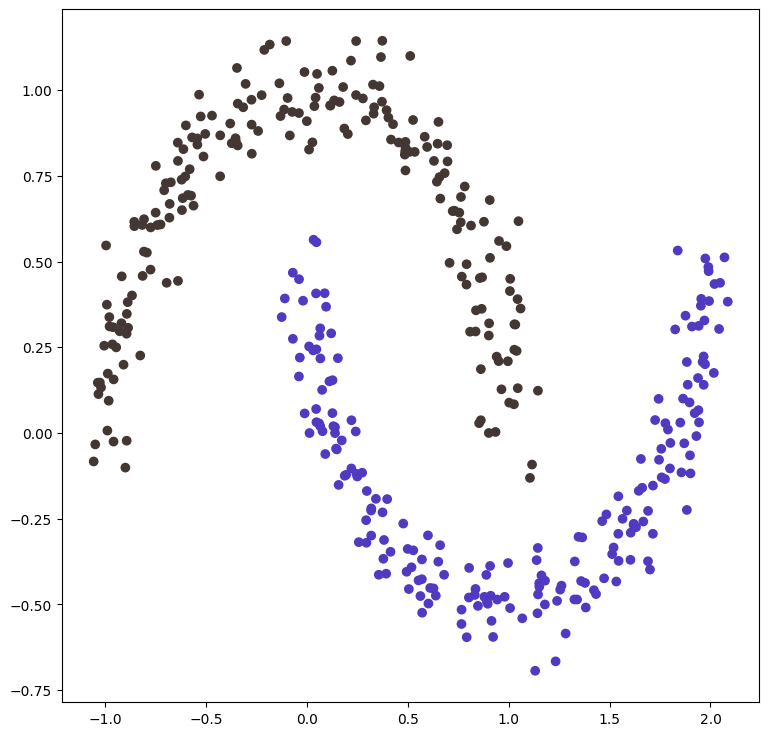

In [155]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [130]:
#from task import KMeans

In [131]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):
        """
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из X,
            3. k-means++ --- центроиды кластеров инициализируются при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None

    def fit(self, X: np.ndarray, y=None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn.
        """
        if self.init == 'sample':
            indices = np.random.choice(len(X), size=self.n_clusters, replace=False)
            centroids = X[indices]
        elif self.init == 'random':
            centroids = np.random.uniform(X.min(axis=0), X.max(axis=0), (self.n_clusters, X.shape[1]))
        elif self.init == 'k-means++':
            centroids = [X[np.random.randint(len(X))]]
            for _ in range(1, self.n_clusters):
                distances = np.array([min(np.linalg.norm(x - centroid) for centroid in centroids) for x in X])
                probabilities = distances ** 2 / np.sum(distances ** 2)
                new_centroid_idx = np.random.choice(len(X), p=probabilities)
                centroids.append(X[new_centroid_idx])
            centroids = np.array(centroids)
        it = 0
        diff = float('inf')
        while it < self.max_iter and diff > 0.001:
            it += 1
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            clusters = np.argmin(distances, axis=1)
            new_centroids = []
            for i in range(self.n_clusters):
                cluster_points = X[clusters == i]
                if len(cluster_points) > 0:
                    new_centroids.append(cluster_points.mean(axis=0))
                else:
                    new_centroids.append(X[np.random.randint(len(X))])
            new_centroids = np.array(new_centroids)
            diff = np.sum(np.linalg.norm(centroids - new_centroids, axis=1))
            centroids = new_centroids
        self.centroids = centroids

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Для каждого элемента из X возвращает номер кластера, к которому относится данный элемент.

        Parameters
        ----------
        X : np.ndarray
            Набор данных, для элементов которого находятся ближайшие кластеры.

        Return
        ------
        labels : np.ndarray
            Вектор индексов ближайших кластеров (по одному индексу для каждого элемента из X).
        """
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

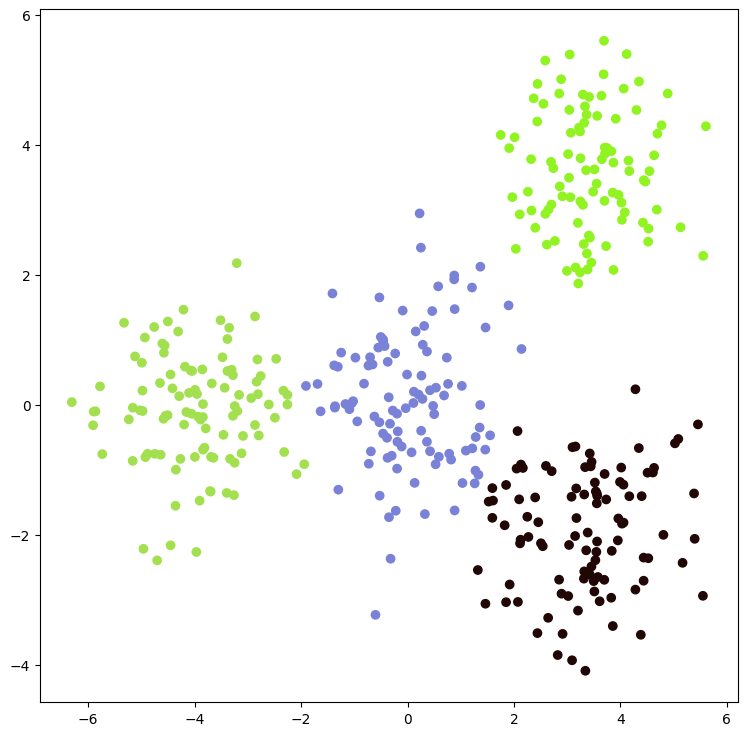

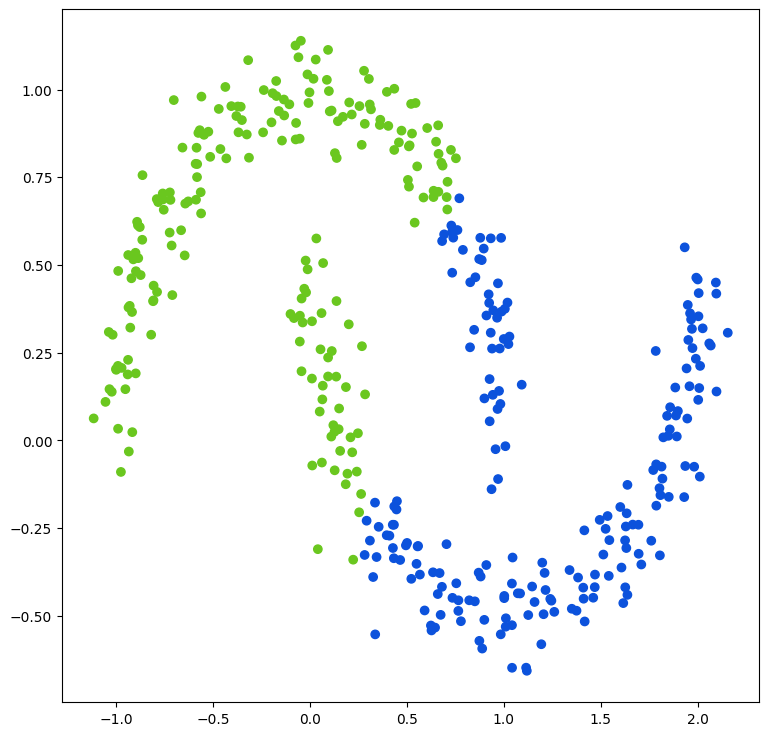

In [132]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels1 = kmeans.predict(X_1)
visualize_clasters(X_1, labels1)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels2 = kmeans.predict(X_2)
visualize_clasters(X_2, labels2)

### Задание 2 (3 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [192]:
from task import DBScan

In [227]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        all_neighbours = tree.query_radius(X, r=self.eps)
        
        def find_query(point):
            return all_neighbours[point]
    
        def expand_cluster(point, neighbours):
            clusters[point] = c
            while neighbours:
                x = neighbours.pop()
                if not visited[x]:
                    visited[x] = 1
                    neighbours_x = find_query(x)
                    if len(neighbours_x) >= self.min_samples:
                        neighbours.extend([y for y in neighbours_x if not visited[y]])
                if clusters[x] == -1:
                    clusters[x] = c
    
        c = -1
        n = len(X)
        visited = np.zeros(n, dtype=bool)
        clusters = np.full(n, -1, dtype=int)
        for i in range(len(X)):
            if visited[i]:
                continue
            visited[i] = 1
            neighbours = deque(find_query(i))
            if len(neighbours) >= self.min_samples:
                c += 1
                expand_cluster(i, neighbours)
        return clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

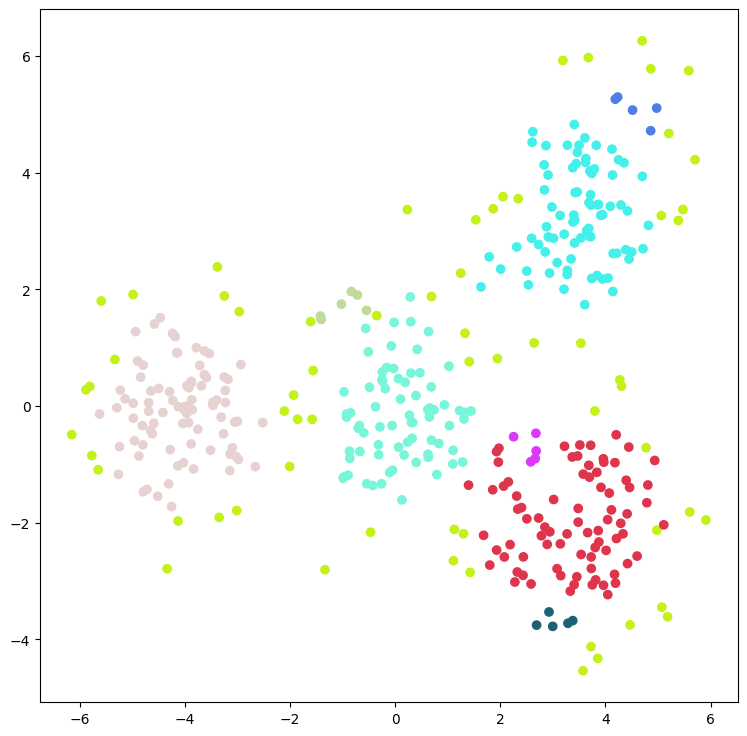

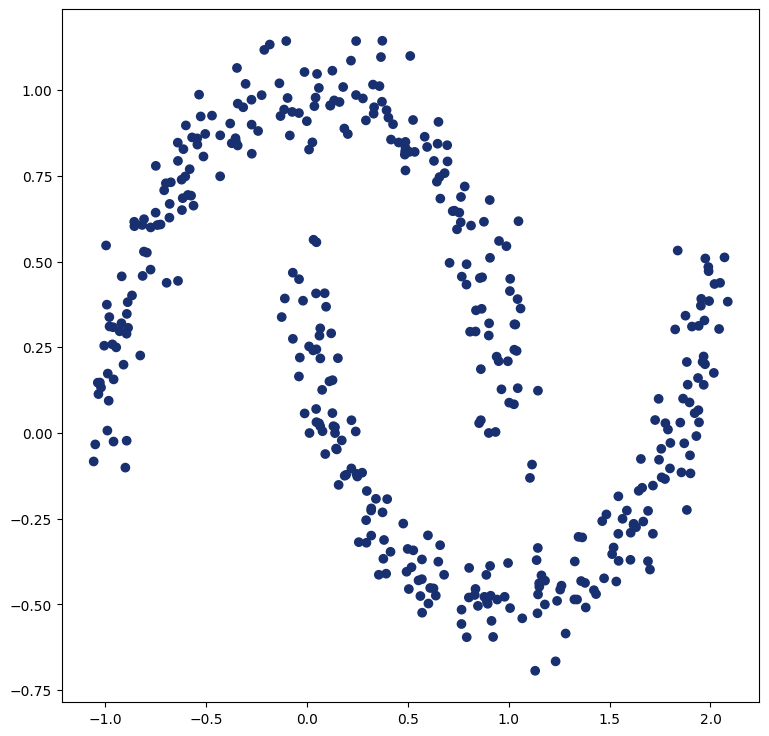

In [228]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan()
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
from task import AgglomerativeClustering

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Дополнительно
Научимся кластеризовать цвета в изображении. Для начала используем OpenCV для того, чтобы считать изображение.

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [ ]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255.
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image * 255), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

In [ ]:
show_image(read_image("./image.png"))

Теперь реализуем функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем применим ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, n_clusters=8, color_scheme="rgb", show_cluster_statisitcs = False):
    orig_image = image
    if color_scheme == "hsv":
        image = cv2.cvtColor((image * 255).astype('float32'), cv2.COLOR_RGB2HSV)
        image /= 255.
    shape = image.shape
    
    small = image[::4,::4,:]
    image = image.reshape((-1, shape[-1]))
    orig_image = orig_image.reshape((-1, shape[-1]))
    X = small.reshape((-1, shape[-1]))
    kmeans = KMeans(max_iter=16, n_clusters=n_clusters, init="k-means++")
    kmeans.fit(X)
    clusters = kmeans.predict(image)
    cluster_colors = kmeans.centorids

    recolored = np.array([cluster_colors[c] for c in clusters]).reshape(shape)
    if color_scheme == "hsv":
        recolored *= 255
        recolored = cv2.cvtColor(recolored.astype('float32'), cv2.COLOR_HSV2RGB) / 255.
    if show_cluster_statisitcs:
        clusters_statistics(orig_image, cluster_colors, clusters)
    return recolored.reshape(shape)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=4)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=8)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=16)
show_image(result)